In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
import matplotlib.pyplot as plt
tqdm_notebook.pandas(desc='PROGRESS>>>')

In [2]:
responses_df = pd.read_csv('responses.csv', encoding="latin1")

In [3]:
def sentiment_score(score):
    if score < 5:
        return 1 #Negative
    elif score > 6:
        return 0 #'positive'
    else:
        return 2 #'neutral'

In [4]:
responses_df['sentiment'] = responses_df['question_response_integer'].progress_apply(sentiment_score)

In [5]:
responses_df['sentiment'].value_counts()

0    12335
1     3906
2     3759
Name: sentiment, dtype: int64

In [6]:
nlp_df = responses_df[['question_response_more', 'sentiment']]

In [7]:
nlp_df.head(20)

,question_response_more,sentiment
0,"I love the leadership team here, and the fact ...",0
1,"While its exciting that we're growing so fast,...",0
2,I like the people I work with. Everyone is re...,0
3,Great people; great Industry; Great collabora...,0
4,Always room for improvement.,0
5,Pumped and loving hanging with the team,0
6,The reorganization and string of firings this ...,1
7,I'm not sure what is happening but lately it's...,1
8,Tolerance and respect seems to be lacking at t...,0
9,I would like my manager to communicate with a ...,1


In [8]:
import re
first_text=nlp_df.question_response_more[0]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

In [9]:
print(nlp_df.question_response_more[0]) #lets review of changings
print(text)

I love the leadership team here, and the fact that there is unlimited room for growth. I've never worked somewhere where the people cared so much. 
i love the leadership team here  and the fact that there is unlimited room for growth  i ve never worked somewhere where the people cared so much  


In [10]:
#stopwords (irrelavent words)
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
text=nltk.word_tokenize(text) #separate all words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khuyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khuyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/khuyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
text

['i',
 'love',
 'the',
 'leadership',
 'team',
 'here',
 'and',
 'the',
 'fact',
 'that',
 'there',
 'is',
 'unlimited',
 'room',
 'for',
 'growth',
 'i',
 've',
 'never',
 'worked',
 'somewhere',
 'where',
 'the',
 'people',
 'cared',
 'so',
 'much']

In [12]:
import nltk as nlp
lemma=nlp.WordNetLemmatizer()
text=[lemma.lemmatize(i) for i in text]
text=" ".join(text)
text

'i love the leadership team here and the fact that there is unlimited room for growth i ve never worked somewhere where the people cared so much'

In [13]:
text_list=[]
for resp in nlp_df.question_response_more:
    text=re.sub("[^a-zA-Z]"," ",str(resp))
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)
    text_list.append(text)

In [14]:
text_list[:10]

['i love the leadership team here and the fact that there is unlimited room for growth i ve never worked somewhere where the people cared so much',
 'while it exciting that we re growing so fast it definitely can make me feel uneasy at time not knowing what s ahead for this company i e not even knowing our plan for even three month out it make job security and projected growth a little hard to know be confident in',
 'i like the people i work with everyone is really kind',
 'great people great industry great collaboration and innovation mediocre compensation recognition and influence',
 'always room for improvement',
 'pumped and loving hanging with the team',
 'the reorganization and string of firing this summer wa disgracefully handled it turned my feeling about the organization from very positive and family like to disgust',
 'i m not sure what is happening but lately it s becoming a little bit toxic in here i can see that people are very grumpy and unhappy',
 'tolerance and respect

In [15]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
max_features=200000
cou_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=cou_vec.fit_transform(text_list).toarray()
all_words=cou_vec.get_feature_names()
print("Most used words: ",all_words[50:100])

Most used words:  ['absoluteley', 'absolutely', 'absolutly', 'absolve', 'absorb', 'absorbed', 'absorption', 'abstract', 'abstraction', 'absurd', 'abundance', 'abuse', 'abused', 'abusing', 'abusive', 'abvancement', 'abw', 'abysmal', 'abyss', 'ac', 'academic', 'academically', 'academy', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accenture', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessability', 'accessed', 'accessibility', 'accessible', 'accessioned', 'accessioning', 'accessory', 'accident', 'accidentally', 'acclamation', 'acclimating', 'acclimatise', 'accolade', 'accommodate', 'accommodating']


In [16]:
from wordcloud import WordCloud

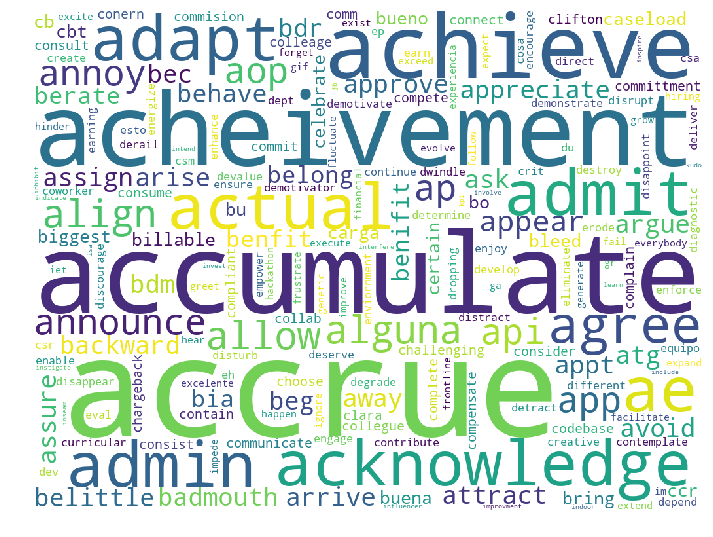

In [17]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words[100:]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
#Split test
y=nlp_df.iloc[:,1].values
x=sparce_matrix
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [19]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)
print("accuracy: ",rf.score(x_test,y_test))

/Users/khuyen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


accuracy:  0.63525


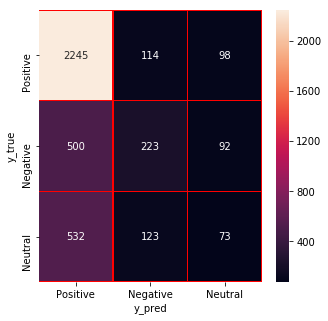

In [20]:
#confussion matrix
y_pred=rf.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [21]:
#logistic Regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("lr accuracy: ",lr.score(x_test,y_test))

lr accuracy:  0.676


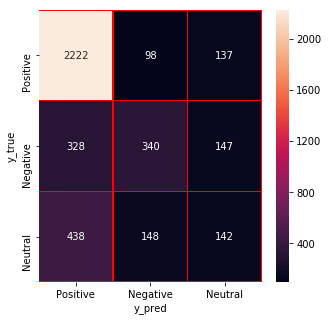

In [22]:
#confussion matrix
y_pred=lr.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()